In [31]:
# !pip install pydicom


In [32]:
import pydicom
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer

import math
import timm
from PIL import Image
from torchvision import transforms
import random
import os


1. Read dicom image

In [33]:
def read_dicom_image(dicom_path):
    # Read DICOM file
    dicom = pydicom.dcmread(dicom_path)

    # Convert pixel data to numpy array
    image = dicom.pixel_array

    # Normalize pixel values to range [0, 1]
    image = image.astype(np.float32) / np.max(image)

    # Convert numpy array to PyTorch tensor
    image_tensor = torch.from_numpy(image)

    # Add batch dimension (if needed)
    image_tensor = image_tensor.unsqueeze(0)

    return image_tensor

In [34]:
def plot_image(image_tensor):
    # Convert PyTorch tensor back to numpy array
    image = image_tensor.squeeze().numpy()

    # Plot the image using matplotlib
    plt.imshow(image, cmap='gray')
    plt.axis('off')  # Hide axis
    plt.show()

torch.Size([1, 2836, 2336])


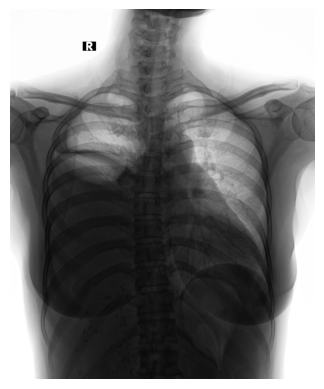

In [35]:
#Test
dicom_path = "/media/jackson/Data/test/0a6fd1c1d71ff6f9e0f0afa746e223e4.dicom"
image_tensor = read_dicom_image(dicom_path)
print(image_tensor.shape)  # Print shape of the image tensor
plot_image(image_tensor)


2. Create Dataset class

In [36]:
class HealthDataset(Dataset):
    def __init__(self, root_dir, transform=None, num_support_image=5, num_query_image=1):
        self.root_dir = root_dir
        self.transform = transform
        self.dicom_files = [f for f in os.listdir(root_dir) if f.endswith('.dicom')]
        self.num_support_image = num_support_image
        self.num_query_image = num_query_image

    def __len__(self):
        return len(self.dicom_files)

    def __getitem__(self, idx):
        dicom_path = os.path.join(self.root_dir, self.dicom_files[idx])
        dicom = pydicom.dcmread(dicom_path)
        image = dicom.pixel_array.astype(np.float32) / np.max(dicom.pixel_array)
        support_image_path_list = [path for path in self.dicom_files if path != self.dicom_files[idx]]
        selected_support_image_paths = random.sample(support_image_path_list, self.num_support_image)

        support_images = []
        for support_image_path in selected_support_image_paths:
            support_dicom_path = os.path.join(self.root_dir, support_image_path)
            support_dicom = pydicom.dcmread(support_dicom_path)
            support_image = support_dicom.pixel_array.astype(np.float32) / np.max(support_dicom.pixel_array)
            support_images.append(support_image)

        if self.transform:
            image = self.transform(image)
            support_images = [self.transform(support_image) for support_image in support_images]
            support_images = torch.stack(support_images, dim = 0)
        return image, support_images

In [37]:
# Test
transform = transforms.Compose([
    transforms.Resize((224,224)),
])
test_dataset = HealthDataset(root_dir="/media/jackson/Data/test", transform=transform)
# plot_image(test_dataset[random.randint(0, len(test_dataset))][0])

# print(test_dataset[0])

2. Data loader

In [38]:
test_loader = DataLoader(dataset=test_dataset, batch_size=4, shuffle=False, drop_last=False)

3. Define model

In [39]:
class ImageEmbedding(nn.Module):
    def __init__(self, model_name, embed_dim, transform_methods ,drop_out = 0.5, device = "cpu"):
        super(ImageEmbedding, self).__init__()

        # Normalize image
        self.normalize = transform_methods

        # Load the specified pre-trained model
        if model_name.startswith('resnet'):
            if model_name == 'resnet50':
                self.model = models.resnet50(pretrained=True)
            elif model_name == 'resnet101':
                self.model = models.resnet101(pretrained=True)
            elif model_name == 'resnet152':
                self.model = models.resnet152(pretrained=True)
            else:
                raise ValueError(f"Unsupported ResNet model: {model_name}")
                
            num_features = self.model.fc.in_features
            self.model.fc = nn.Linear(num_features, embed_dim)
        
        elif model_name.startswith('densenet'):
            if model_name == 'densenet121':
                self.model = models.densenet121(pretrained=True)
            else:
                raise ValueError(f"Unsupported DenseNet model: {model_name}")
                
            num_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(num_features, embed_dim)
        
        elif model_name.startswith('vit'):
            self.model = timm.create_model(model_name, pretrained=True)

            num_features = self.model.head.in_features
            self.model.head = nn.Linear(num_features, embed_dim)
        
        else:
            raise ValueError(f"Unsupported model: {model_name}")
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=drop_out)
        self.device = device
    def forward(self, image):
        image = self.normalize(image)
        image = image.to(self.device)
        image = torch.unsqueeze(image, dim=0)
        features = self.model(image)
        features = self.relu(features)
        features = self.dropout(features)
        return features

In [40]:
class PositionalEncoding(nn.Module):
    def __init__(self):
        super(PositionalEncoding, self).__init__()

    def forward(self, x):
        max_len, d_model = x.size(1), x.size(2)
        encoding = self.positional_encoding(max_len, d_model, device=x.device, dtype=x.dtype)
        encoding = encoding.expand(x.size(0), -1, -1)
        x = x + encoding.squeeze(0)  # Sử dụng squeeze để loại bỏ chiều batch nếu cần
        return x

    def positional_encoding(self, max_len, d_model, device, dtype):
        position = torch.arange(0, max_len, dtype=dtype, device=device).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=dtype, device=device) * (-math.log(10000.0) / d_model))

        encoding = torch.zeros(1, max_len, d_model, dtype=dtype, device=device)
        encoding[:, :, 0::2] = torch.sin(position / div_term)
        encoding[:, :, 1::2] = torch.cos(position / div_term)

        return encoding

In [41]:
import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class FeatureEncoding(nn.Module):
    def __init__(self, d_model=512, nhead=2, dim_feedforward=1024, n_layer=2, drop_out=0.5, output_dim=512, device="cpu"):
        super(FeatureEncoding, self).__init__()
        encoder_layers = TransformerEncoderLayer(d_model, nhead, dim_feedforward, drop_out).to(device)
        self.transformer_model = TransformerEncoder(encoder_layers, n_layer).to(device)
        self.fc = nn.Linear(d_model, output_dim)
        self.device = device

    def forward(self, features):
        # Kiểm tra kích thước của features
        assert len(features.shape) == 4, "Input features should have shape (batch_size, num_samples, sequence_length, d_model)"
        
        batch_size, num_samples, sequence_length, input_dim = features.size()
        
        # Kiểm tra kích thước của features
        assert input_dim == 512, f"Expected input dimension of 512, but got {input_dim}"
        
        # Reshape features để có kích thước (batch_size * num_samples, sequence_length, d_model)
        features = features.view(batch_size * num_samples, sequence_length, input_dim)
        
        features = features.to(self.device)
        features = self.transformer_model(features)
        features = self.fc(features)
        
        # Reshape lại để có kích thước ban đầu (batch_size, num_samples, sequence_length, output_dim)
        features = features.view(batch_size, num_samples, sequence_length, -1)
        
        return features


In [42]:
class RankingModel(nn.Module):
    def __init__(self, model_name, embed_dim, transform_methods, drop_out,d_model = 512, nhead = 2, dim_feedforward = 1024, n_layer = 2, output_dim = 1024, device = "cpu"):
        super(RankingModel, self).__init__()
        self.embedding = ImageEmbedding(model_name=model_name, embed_dim=embed_dim, transform_methods=transform_methods, drop_out=drop_out, device=device).to(device)
        self.position_model = PositionalEncoding().to(device)
        self.encoding = FeatureEncoding(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, n_layer=n_layer, drop_out=drop_out, output_dim=output_dim, device=device).to(device)

        self.device = device

    def forward(self, support_images, query_image):
        #Encoder support images
        encoded_features_list = []
        for image in support_images:
            encoded_features = self.embedding(image)
            encoded_features_list.append(encoded_features)

        encoded_support_tensor = torch.concat(encoded_features_list)        
        encoded_support_tensor = self.position_model(encoded_query_tensor)
        encoded_support_tensor = self.encoding(encoded_support_tensor)
        print("Support:" + str(encoded_support_tensor.size()))
        #Encoder query image
        encoded_query_tensor = self.embedding(query_image).unsqueeze(1)
        print("Query:" + str(encoded_query_tensor.size()))
        # CLIP Ideal
        cos_sim = F.cosine_similarity(encoded_query_tensor, encoded_support_tensor, dim=2)
        softmax_scores = F.softmax(cos_sim, dim=-1)
        return softmax_scores

In [58]:
#Test
embed_size = 512  # Set the desired output size of the encoder
model_name = 'vit_base_patch16_224'  # Choose the desired ViT model
drop_out = 0.5
transform_method = transforms.Compose([
    transforms.Resize(224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)
HealthyRankingModel = RankingModel(model_name=model_name, embed_dim=embed_size, transform_methods=transform, drop_out=drop_out, d_model = 512, nhead = 2, dim_feedforward = 1024, n_layer = 2, output_dim = 512, device="cpu")


test_dataset = HealthDataset(root_dir="/media/jackson/Data/test", transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=4)



/home/jackson/anaconda3/envs/Paper/lib/python3.8/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


TypeError: img should be PIL Image. Got <class 'numpy.ndarray'>